# homework 04: a plague of sand mice

In addition to imports, I prefer to list all functions at the top of the notebook. Below are the packages and functions I'll use to complete this assignment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

In [2]:
def ReadFASTA(filename):
    '''
    Given: File in FASTA format (sequence names denoted by '>', next line is sequence)
    Return: Gene names and sequences into a two-member list of lists
    '''
    names = [] # empty list of sequence names
    seqs = [] # empty list of sequences
    
    with open(filename) as fasta:
        seq = "" # empty string for the current sequence
        
        for line in fasta:
            if not line: continue # skip line if blank
            
            if line[0] == '>': # if '>', get sequence name
                names.append(line.rstrip('\n').replace('>','')) # add seq name, remove '>' from sequence line
                
                if not seq: continue # if a sequence string isn't stored, don't append to sequence list
                
                else: # if a sequence has been stored and a new '>' is encountered...
                    seqs.append(seq) # append to sequence list and... 
                    seq = "" # re-initialize seq string
            
            elif line[0] != '>': # if not 
                seq += line.rstrip('\n')
                
        seqs.append(seq) # Read final sequence into data list
    
    return names, seqs

def GetScore(dat, values = 'ACGT', value_weight = [1,-1,-1,1]):
    '''
    Given: a list dataset, all potential values in the observation, a list of weights for each observation
    Return: a scored dataset
    '''
    value_list = list(values) # create a list out of the weights matrix
    scores = np.zeros(len(dat)) # initialize scores array
    
    for i, sequence in enumerate(dat):
        score = 0 # initialize score for each data point
        
        for j, value in enumerate(value_list):
            score += sequence.count(value) * value_weight[j] # add up scores based on weight
        scores[i] = score # place score into relevant position
        
    return scores

def ComputeConfusion(positive_dat, negative_dat, threshold_num = 100):
    '''
    Given: two equal length data lists (one "positive", one "negative") and a desired number of cutoff values
    Return: whether each dataset would be considered true positive/false negative or false positive/true negative
    '''
    # note that this requires numpy imported as np
    
    # get min and max scores from all data, use limits to determine range of cutoff values for calling positive/negative
    min_score = np.min([positive_dat, negative_dat])
    max_score = np.max([positive_dat, negative_dat])
    threshold_scores = np.linspace(min_score, max_score, threshold_num)
    
    # initialize all classifications
    TP = np.zeros(threshold_num)
    FP = np.zeros(threshold_num)
    FN = np.zeros(threshold_num)
    TN = np.zeros(threshold_num)
    
    # compute classifications based on cutoff values. assign equal values to positive
    for i, score in enumerate(threshold_scores):
        TP[i] = sum(positive_dat >= score)
        FP[i] = sum(negative_dat >= score)
        FN[i] = sum(positive_dat < score)
        TN[i] = sum(negative_dat < score)
    
    # return confusion matrix in [0] and [1], cutoff values in [2] to do further calculations
    return [[TP,FP],[FN,TN],threshold_scores]

def ComputeRates(confusion_matrix):
    '''
    Given: a confusion matrix (0,0 = TP; 0,1 = FP; 1,0 = FN; 1,1 = TN)
    Return: rates for each classification
    '''
    TPR = confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[1][0]) # TP/(TP + FN)
    FPR = confusion_matrix[0][1]/(confusion_matrix[0][1] + confusion_matrix[1][1]) # FP/(FP + TN)
    FNR = confusion_matrix[1][0]/(confusion_matrix[1][0] + confusion_matrix[0][0]) # FN/(TP + FN)
    TNR = confusion_matrix[1][1]/(confusion_matrix[1][1] + confusion_matrix[0][1]) # TN/(FP + TN)
    
    return [[TPR,FPR],[FNR,TNR]]

def GetAUC(TPR,FPR):
    '''
    Given: a true positive rate and a false positive rate (or any x and y list)
    Return: a trapezoidal area under the curve estimation (crude integration)
    '''
    # note: compared this to sklearn.metrics.roc_auc_score, achieved similar results to 3rd decimal in multiple models
    # note: these values are non-normalized. if normalized data are desired, input values should be normalized
    
    auc = 0
    for i in range(len(TPR[:-1])):
        auc += ((TPR[i] + TPR[i+1]) / 2) * (FPR[i] - FPR[i+1]) # trapezoid area formula ((a+b)/2)*h
        
    return round(auc, 3)

def GetMers(n, values = 'ACGT'):
    '''
    Given: the number of draws to take from input values and string containing input values
    Return: a list of all combinations of input values (with replacement)
    '''
    # note that this requires itertools.product imported as product
    
    mer_list = list(product(values, repeat=n)) # create list of tuples of all combinations of values, repeated n times 
    mers = [] # initialize final list
    
    for mer in mer_list:
        mers.append(''.join(mer)) # combine tuples into a single single
    
    return mers

def TrainMarkov(train_data, unique_list):
    '''
    Given: a training dataset and a list of unique combinations of values (could be generated by GetMers)
    Return: a list of likelihoods, denoting number of times the value appears in the training dataset
    '''
    look_ahead = len(unique_list[0]) # get the length of a "mer"
    unique_count = np.zeros(len(unique_list)) # initialize the frequency counter
    
    for i, sequence in enumerate(train_data):
        # within an observation of the training data, iterate until attempting to iterate further would exceed seq length:
        
        for j in range(len(sequence)-(look_ahead-1)):
            mer = sequence[j:j+look_ahead] # get current "mer"
            unique_count[unique_list.index(mer)] += 1 # find the "mer" index in the list of values, add to the count
            
    return unique_count/sum(unique_count) # normalize the counts such that the total sum would add to 1

def TestMarkov(test_data,order,initial_list,full_list,pos_likelihoods,neg_likelihoods, values = 'ACGT'):
    '''
    Given: test dataset, Markov order, list of n and n+1 length "mers", likelihoods for "positive" and "negative" datasets
    Return: log likelihood ratio (log-odds score)
    '''
    # initialize arrays to hold classification probabilities for each test observation
    pos_probs = np.zeros(len(test_data))
    neg_probs = np.zeros(len(test_data))
    
    # get the number of potential values in the dataset to find correct indices for marginal probability calculations
    # note that this assumes the "mer" lists are in the "correct" order created by itertools.product
    # please ensure the values variable in this function is equal (in content and order) to variable in GetMers
    value_num = len(set(values))
    
    # iterate through each sequence and calculate initial probability under each dataset
    for i, sequence in enumerate(test_data):
        mer = sequence[:order] # get the initial sequence
        idx = initial_list.index(mer) # find the initial "mer"
        
        # get marginal probability of initial by summing over all n initial "mers" in the full n+1 length list of "mers"
        # again, finding the correct positions depends on the "mers" being generated in a predictable way, described above
        idx_start = idx*value_num # get the starting index for the position of the initial
        idx_end = idx*value_num + value_num # get the ending index for the position of the initial
        pos_probs[i] = np.log(sum(pos_likelihoods[idx_start:idx_end])) # calculate initial probabilities for "positive" data
        neg_probs[i] = np.log(sum(neg_likelihoods[idx_start:idx_end])) # calculate initial probabilities for "negative" data
        
        # calculate the probability of each value given the initial values under both "positive" and "negative" models
        for j in range(len(sequence[:-order])):
            # steps for initial are same as above.
            initial_mer = sequence[j:j+order]
            idx_initial = initial_list.index(initial_mer)
            init_start = idx_initial*value_num
            init_end = idx_initial*value_num + value_num
            
            full_mer = sequence[j:j+order+1] # get the full conditional sequence
            idx_full = full_list.index(full_mer) # find the index of the full sequence
            
            # calculate a conditional probability, converting logarithm of ratio -> difference of logs
            pos_probs[i] += np.log(pos_likelihoods[idx_full]) - np.log(sum(pos_likelihoods[init_start:init_end]))
            neg_probs[i] += np.log(neg_likelihoods[idx_full]) - np.log(sum(neg_likelihoods[init_start:init_end]))
                
    return pos_probs - neg_probs # calculate and return log-odds score

# testing Moriarty's method

Now that I've loaded all my packages and functions, I'll begin testing Moriarty's method for myself. Moriarty seems to have created a perfect classifier. However, it distinguishes the pathogen's from random sequences. I'm not sure what application this would be useful for other than confirming the pathogen wasn't created by a random nucleotide generator...

Below, I'll use Moriarty's scoring method (+1 for A and T, -1 for C and G) to compare both his random sequences and the sand mouse sequences to the pathogen sequences.

In [3]:
# Read in data, select only sequences from the .fa files (sequence names not needed)
sand_data = ReadFASTA('sandmouse.fa')[1]
path_data = ReadFASTA('pathogen.fa')[1]
rand_data = ReadFASTA('moriarty-neg.fa')[1]

In [4]:
# Use Moriarty's method to score each dataset
sand_scores = GetScore(sand_data)
path_scores = GetScore(path_data)
rand_scores = GetScore(rand_data)

Text(0, 0.5, 'Count')

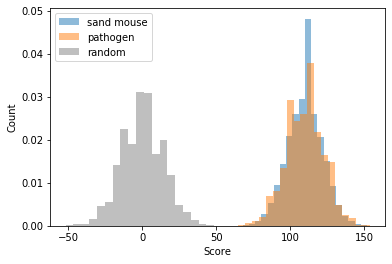

In [5]:
# Plot histograms of scores for each dataset with 50% transparency to see any overlap
plt.hist(sand_scores, alpha = 0.5, bins = 20, density = True, label = 'sand mouse')
plt.hist(path_scores, alpha = 0.5, bins = 20, density = True, label = 'pathogen')
plt.hist(rand_scores, alpha = 0.5, bins = 20, density = True, color = 'gray', label = 'random')
plt.legend()
plt.xlabel('Score')
plt.ylabel('Count')

It looks like I've recreated some of Moriarty's results. The pathogen sequences clearly have scores far greater than the random sequences, indicating that they're relatitvely AT-rich. Unfortunately the sand mouse sequences also appear to be AT-rich. In fact, the score distribution seems almost indistinguishable from the pathogen data.

I can summarize the ability to correctly classify pathogen vs. random and pathogen vs. sand mouse sequences using ROC curves and AUC values

In [6]:
# Generate confusion matrices for pathogen data vs random data and sand mouse data
rand_confusion = ComputeConfusion(path_scores, rand_scores)
sand_confusion = ComputeConfusion(path_scores, sand_scores)

In [7]:
# Compute classification rates for each model
rand_rates = ComputeRates(rand_confusion)
sand_rates = ComputeRates(sand_confusion)

In [8]:
# Approximate area under the curve for each model
rand_auc = GetAUC(rand_rates[0][0],rand_rates[0][1])
sand_auc = GetAUC(sand_rates[0][0],sand_rates[0][1])

Text(0.5, 1.0, 'random model vs. sand mouse model')

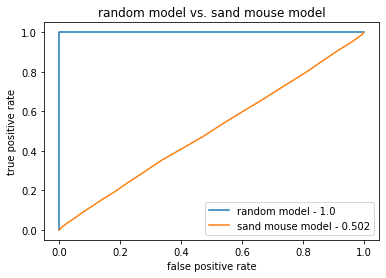

In [9]:
# Plot ROC curves using Moriarty's method
plt.plot(rand_rates[0][1],rand_rates[0][0], label='random model - ' + str(rand_auc))
plt.plot(sand_rates[0][1],sand_rates[0][0], label='sand mouse model - ' + str(sand_auc))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('random model vs. sand mouse model')

Using Moriarty's method, I've confirmed that pathogen vs. random is a perfect classifier. Unfortunately pathogen vs. sand mouse is a useless classifier, basically equivalent to flipping a (fair) coin and assigning species based on heads or tails. I'll have to develop a better method to distinguish the sequences

# markov model

We're instructed to create a 2nd order Markov model for this pset. The first step I'll take in creating this model is determining all possible n-length and n+1 combinations of nucleotides, where n is the order of the Markov model. The n-length combinations will be used for initial probabilities and the n+1 combinations for the initial sequence and the additional nucleotide.

In [10]:
# Generate list of "mers" for initial and conditional lists of possible sequences
initials = GetMers(2)
fulls = GetMers(3)

Next, I'll split the data into a training set and a testing set. This will be a 50/50 split, as suggested by the pset.

In [11]:
# Split data to halves: training set and test set
# This method assumes data is already randomized and just takes first half and second half of data
sand_train = sand_data[:int(len(sand_data)/2)]
sand_test = sand_data[int(len(sand_data)/2):]

path_train = path_data[:int(len(path_data)/2)]
path_test = path_data[int(len(path_data)/2):]

Now the model will be trained. This entails taking each dataset and determining the frequency with which each possible n+1 length sequence appears in each dataset. These frequencies will be normalized to the total number of evaluated n+1 mers and output as the "likelihoods" variables.

I chose not to calculate likelihoods for the n-length mers and instead to sum over all n-length mers in the n+1 mer list of likelihoods. In my tests, the results were generally equivalent to 2 or 3 decimal places, and I figured the marginalization method was more generalizable and technically more accurate.

In [12]:
# Train the model by determining frequencies of each unique mer occurring in either dataset
sand_likelihoods = TrainMarkov(sand_train,fulls)
path_likelihoods = TrainMarkov(path_train,fulls)

Finally, evaluate the model and generate the log-odds scores using the test datasets.

In [13]:
# Generate list of log-odds scores
sand_markov_scores = TestMarkov(sand_test,2,initials,fulls,path_likelihoods,sand_likelihoods)
path_markov_scores = TestMarkov(path_test,2,initials,fulls,path_likelihoods,sand_likelihoods)

Now that we have our scores, I can repeat the steps I took for comparing models using Moriarty's method: plotting the distribution of scores, calculating values to perform further analysis (e.g. sensitivity, FPR, FDR), and plotting a ROC curve.

Text(0, 0.5, 'Count')

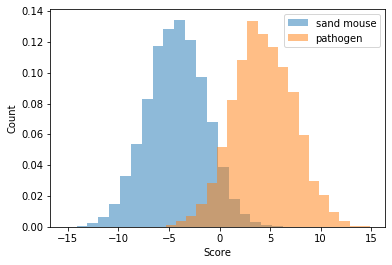

In [14]:
# Plot distribution of LLRs
plt.hist(sand_markov_scores, alpha = 0.5, bins = 20, density = True, label = 'sand mouse')
plt.hist(path_markov_scores, alpha = 0.5, bins = 20, density = True, label = 'pathogen')
plt.legend()
plt.xlabel('Score')
plt.ylabel('Count')

These histograms look much better than the completely overlapped histograms observed above. We can compare the models more directly using ROC curves.

In [15]:
# Calculate confusion matrix, classification rates, and AUC value
markov_confusion = ComputeConfusion(path_markov_scores, sand_markov_scores)
markov_rates = ComputeRates(markov_confusion)
markov_auc = GetAUC(markov_rates[0][0],markov_rates[0][1])

Text(0, 0.5, 'true positive rate')

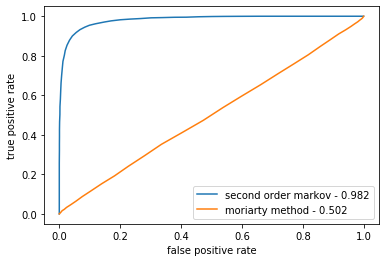

In [16]:
# Plot 2nd order Markov model, compare to Moriarty's method
plt.plot(markov_rates[0][1],markov_rates[0][0], label='second order markov - ' + str(markov_auc))
plt.plot(sand_rates[0][1],sand_rates[0][0], label='moriarty method - ' + str(sand_auc))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

This model seems to have worked well, especially in comparison to Moriarty's method. The AUC of 0.982 is quite good (I think). However, the utility of this model actually being used to detect pathogen sequences will be evaluated in the next section.

# how good is this method?

To evaluate how useful this method is, I'll need to understand additional metrics about the model. Things like sensitivity, specificity, false positive rate, false detection rate, positive predictive value, and negative predictive value are all important in determining how good a classifier is when being applied to data. Many of these metrics incorporate population frequency, which as we're all learning, matters greatly when interpreting the results of a classifier (or viral test).

In [17]:
# Convert rate matrices and thresholds to something more brief and interpretable
TPR = markov_rates[0][0]
FPR = markov_rates[0][1]
FNR = markov_rates[1][0]
TNR = markov_rates[1][1]
thresholds = markov_confusion[2]

In [18]:
sensitivity = 0.9 # set sensitivity value based on lab's desired sensitivity of 90%

threshold_index = np.max(np.where(TPR >= sensitivity)) # determine index value of threshold for desired sensitivity

estFPR = FPR[threshold_index]/(FPR[threshold_index] + TNR[threshold_index]) # perform FP/(FP + TN) at threshold value
print('Estimated false positive rate at {}% sensitivity is {}.'.format(sensitivity*100,estFPR))

pos_freq = 0.01 # frequency of true positives (pathogen sequences) in sample
neg_freq = 0.99 # frequency of true negatives (sand mouse sequences) in sample
FDR = (FPR*neg_freq)/((FPR*neg_freq)+(TPR*pos_freq)) # create array of FDR values at all thresholds
estFDR = FDR[threshold_index] # determine FDR at selected threshold
print('Estimated false detection rate at {}% sensitivity is {}.'.format(sensitivity*100,round(estFDR,3)))

Estimated false positive rate at 90.0% sensitivity is 0.043.
Estimated false detection rate at 90.0% sensitivity is 0.825.


In [19]:
# Alternatively, these values could've been calculated using a threshold value:

threshold = thresholds[threshold_index] # Extract the log-odds scores of the threshold based on desired sensitivity

# Calculate the number of false positives and all negative data values
num_FP = sum(sand_markov_scores > threshold) # model called false positives
num_neg = len(sand_markov_scores) # data-determined negatives
estFPR = num_FP/num_neg # incorrectly called positives divided by all data-determined negatives
print('Estimated false positive rate at {}% sensitivity is {}.'.format(sensitivity*100,estFPR))

# Calculate the number of true positives and predicted false detections
num_TP = sum(path_markov_scores > threshold) # number of correctly called positives
estFDR = (num_FP*neg_freq)/(num_FP*neg_freq + num_TP*pos_freq) # incorrectly called positives divided by all called positives
print('Estimated false detection rate at {}% sensitivity is {}.'.format(sensitivity*100,round(estFDR,3)))

Estimated false positive rate at 90.0% sensitivity is 0.043.
Estimated false detection rate at 90.0% sensitivity is 0.825.


At 90% sensitivity, the model does a pretty good job of avoiding false positives. Only 4.3% of sand mouse sequences would be incorrectly classified as pathogen sequences. 

Unfortunately, the false positive rate doesn't account for potential differences in proportions between negative (sand mouse) and positive (pathogen) sequences. We account for those in the false detection rate, which is 82.5%. This indicates that when a positive sequence is determined by the model, almost 5 out of 6 times, the sequence will actually be a sand mouse transcript.

I don't think this means the classifier is useless. However, in order to have more certainty about which sequences belong to the pathogen, the desired sensitivity would need to be decreased. Around a sensitivity of ~25%, no sand mouse sequences in the test data have a high enough LLR to be classified as positive, making both the estimated false positive rate and estimated false detection rate 0%. This may be too low of a sensitivity for the lab's values, but it would result in being able to have extremely high confidence that any positively classified observations are true positives.

# higher order markov models?

The only ways I could think of to make the model more useful would either be to change the composition of the RNAseq samples (maybe some sort of sand mouse depletion method prior to running the RNAseq protocol) or to improve the model. Simulating a sand mouse depletion by changing the frequencies seemed silly, so I chose to improve the model.

I assumed the model was chosen to run as a 2nd order as a mix of being computationally manageable while also representing the triplet code of the genome. We would expect that, after a start sequence, every third nucleotide is associated with the previous two because the three nucleotides together would form a limited set of (largely redundant) codons. Using this idea and the ideas discussed in class, I wondered if a 5th order Markov model would do a better job of separating sand mouse and pathogen sequences.

In order to test this, I attempted to create a 5th order Markov model. Unfortunately, I quickly ran into an issue: there were about a dozen potential combinations of 6 nucleotides that didn't appear in the pathogen dataset or in the sand mouse dataset (but not the same hexamers in both datasets). These probabilities came up as 0 in the likelihood variable, leading to an undefined value when applying the np.log function. To circumvent this issue, I added a small value (1e-7) to _all_ probabilities while testing the model. This was ~10x smaller than any probability observed in the hexamer likelihoods and in my tests, this did not change AUC values (at least to 3 decimal places). 

For brevity, I also created a function that would allow me to run through the entire model generation process in a single line. In order to show the progression from lower to higher order models, I created several models, from 1st order to 5th order. For consistency, I used the modified function for all models tested below.

Note that this extraneous portion of the notebook might take a while to run (~15 mins on my computer). Definitely no need to run on yours!

In [20]:
def TestMarkovHighOrder(test_data,order,initial_list,full_list,pos_likelihoods,neg_likelihoods, not_zero, values = 'ACGT'):
    '''
    All documentation similar to TestMarkov. Only difference is that 'not_zero' is added to all probability calculations
    This addition avoids taking log(0). not_zero value should ideally be small enough to not affect model result
    '''
    pos_probs = np.zeros(len(test_data))
    neg_probs = np.zeros(len(test_data))
    value_num = len(set(values))
    
    for i, sequence in enumerate(test_data):
        mer = sequence[:order]
        idx = initial_list.index(mer)
        idx_start = idx*value_num
        idx_end = idx*value_num + value_num
        pos_probs[i] = np.log(sum(pos_likelihoods[idx_start:idx_end]+not_zero))
        neg_probs[i] = np.log(sum(neg_likelihoods[idx_start:idx_end]+not_zero))

        for j in range(len(sequence[:-order])):
            initial_mer = sequence[j:j+order]
            idx_initial = initial_list.index(initial_mer)
            init_start = idx_initial*value_num
            init_end = idx_initial*value_num + value_num
            full_mer = sequence[j:j+order+1]
            idx_full = full_list.index(full_mer)      
            pos_probs[i] += np.log(pos_likelihoods[idx_full]+not_zero) - np.log(sum(pos_likelihoods[init_start:init_end]+not_zero))
            neg_probs[i] += np.log(neg_likelihoods[idx_full]+not_zero) - np.log(sum(neg_likelihoods[init_start:init_end]+not_zero))
                
    return pos_probs - neg_probs

def RunMarkov(pos_data,neg_data,order,title = 'Markov Model', labels = ['pathogen', 'sand mouse'], data_split = 5000, values = 'ACGT'):
    '''
    Given: two datasets, a Markov order, an index of where to split the data into train and test
    Return: confusion matrix, classification rates, AUC score. Also, plot the LLRs
    '''
    initials = GetMers(order, values) # get list of initial "mers"
    fulls = GetMers(order+1, values) # get list of conditional "mers"
    
    # split data into train and test sets
    pos_train = pos_data[:data_split]
    pos_test = pos_data[data_split:]   
    neg_train = neg_data[:data_split]
    neg_test = neg_data[data_split:]    

    # determine likelihood values for each dataset
    pos_likelihoods = TrainMarkov(pos_train,fulls)
    neg_likelihoods = TrainMarkov(neg_train,fulls)
    
    # set value to add to likelihoods to avoid taking log of 0 with high order models
    not_zero = 1e-7 # chosen based on minimum probability value of ~1e-6

    # calculate LLRs for each model
    pos_scores = TestMarkovHighOrder(pos_test,order,initials,fulls,pos_likelihoods,neg_likelihoods, not_zero, values)
    neg_scores = TestMarkovHighOrder(neg_test,order,initials,fulls,pos_likelihoods,neg_likelihoods, not_zero, values)
    
    # plot LLRs
    plt.hist(neg_scores, alpha = 0.5, bins = 20, density = True, label = labels[1])
    plt.hist(pos_scores, alpha = 0.5, bins = 20, density = True, label = labels[0])
    plt.legend()
    plt.title(title)
    plt.xlabel('score')
    plt.ylabel('frequency')
    
    # calculate confusion matrix, classification rates, AUC
    confusion = ComputeConfusion(pos_scores, neg_scores)
    rates = ComputeRates(confusion)
    auc = GetAUC(rates[0][0],rates[0][1])
    
    # return list of lists containing confusion matrix, classification rates, area under the curve
    return confusion, rates, auc

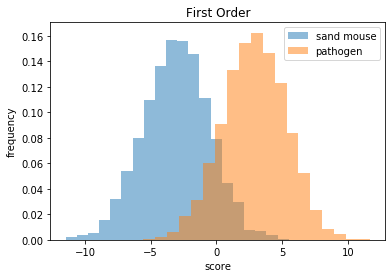

In [21]:
first_confusion, first_rates, first_auc = RunMarkov(path_data,sand_data,1,'First Order')

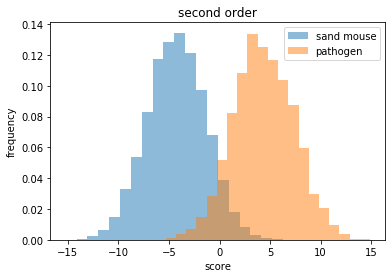

In [22]:
second_confusion, second_rates, second_auc = RunMarkov(path_data,sand_data,2,'second order')

In [ ]:
third_confusion, third_rates, third_auc = RunMarkov(path_data,sand_data,3,'third order')

In [ ]:
fourth_confusion, fourth_rates, fourth_auc = RunMarkov(path_data,sand_data,4,'fourth order')

In [ ]:
fifth_confusion, fifth_rates, fifth_auc = RunMarkov(path_data,sand_data,5,'fifth order')

In [ ]:
plt.plot(first_rates[0][1],first_rates[0][0], label='first order - ' + str(first_auc))
plt.plot(second_rates[0][1],second_rates[0][0], label='second order - ' + str(second_auc))
plt.plot(third_rates[0][1],third_rates[0][0], label='third order - ' + str(third_auc))
plt.plot(fourth_rates[0][1],fourth_rates[0][0], label='fourth order - ' + str(fourth_auc))
plt.plot(fifth_rates[0][1],fifth_rates[0][0], label='fifth order - ' + str(fifth_auc))
plt.legend()
plt.title('markov model comparison')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

I expected the first order model to have a lower AUC than the second order. With the third and fourth order models, I assumed they were effectively equivalent to the second order model. But I was surprised to see the fifth order model have a _decreased_ AUC compared to the second order model.

I think the simplest explanation I could come up with is that these datasets are not real and might have been generated as independent triplets (which would partially explain why we were instructed to created second order models) rather than protein-coding triplets that might have some association with adjacent amino acid residues. Maybe including an additional, independent, but internally associated triplet decreased the model's ability to discern sequence origin.

In any case, choosing to do this forced me to create very generalizable functions in order to rapidly re-run without much additional scripting. So hopefully this will be useful for any future modeling I do!